In [1]:
import pandas as pd
import numpy as np
raw_df = pd.read_csv('TIMESERIES_all_monthly_enriched_no_dairyntel.csv').ffill()

In [2]:
def remove_invalid_features(df, min_num_valid=100):
    v_check = df.ffill().isna().sum() < len(df) - min_num_valid
    v_feats = v_check[v_check].index.tolist()
    return [f for f in v_feats if len(df[f].unique()) > 1]

def prepare_data(time_horizon, target_var = "ZuivelNL - Dutch SMP food quotation"):
    input_df = raw_df.copy() 
    input_df['Target'] = -np.sign(input_df[target_var].diff(-time_horizon))
    input_df['date'] = pd.to_datetime(input_df.apply(lambda x: x['date'][:10],axis=1))
    valid_feats = remove_invalid_features(input_df, 99+time_horizon)
    data = input_df[valid_feats].dropna()
    data['Target'] = data['Target'].astype('int')
    return data

In [3]:
data = prepare_data(time_horizon=6)

In [4]:
import pycaret
from pycaret.classification import *
params = {
    'target': 'Target',
    'train_size':0.9,
    'normalize' : True,
    'silent':True,
    'feature_selection':True,
    'feature_selection_threshold':0.1,
}
exp_clf = setup(data, **params)
# compare_models()

 
Setup Succesfully Completed!


,Description,Value
0,session_id,6038
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(100, 1621)"
4,Missing Values,False
5,Numeric Features,1567
6,Categorical Features,52
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


IntProgress(value=0, description='Processing: ', max=170)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:38:45
Status,. . . . . . . . . . . . . . . . . .,Compiling Final Model
ETC,. . . . . . . . . . . . . . . . . .,0.0 Seconds Remaining


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Linear Discriminant Analysis,0.9000,0.9650,0.910,0.9148,0.8984,0.7966
1,Extra Trees Classifier,0.9000,0.9575,0.865,0.9433,0.8919,0.7979
2,Logistic Regression,0.8889,0.9400,0.905,0.8981,0.8842,0.7702
3,K Neighbors Classifier,0.8889,0.9275,0.930,0.8939,0.8984,0.7677
4,SVM - Linear Kernel,0.8889,0.0000,0.845,0.9383,0.8786,0.7770
5,Ridge Classifier,0.8667,0.0000,0.885,0.8814,0.8692,0.7286
6,Random Forest Classifier,0.8444,0.8975,0.820,0.8933,0.8363,0.6813
7,Gradient Boosting Classifier,0.8333,0.8650,0.875,0.8438,0.8423,0.6715
8,Ada Boost Classifier,0.8111,0.8350,0.820,0.8455,0.8107,0.6129
9,Naive Bayes,0.7778,0.8025,0.700,0.8717,0.7426,0.5424


KeyboardInterrupt: 

In [5]:
lr_model = tune_model('lr' ,n_iter=100)
lr_model

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8889,0.9000,1.0000,0.8333,0.9091,0.7692
1,0.7778,0.8000,1.0000,0.7143,0.8333,0.5263
2,0.8889,1.0000,0.8000,1.0000,0.8889,0.7805
3,0.8889,1.0000,1.0000,0.8333,0.9091,0.7692
4,0.8889,1.0000,1.0000,0.8000,0.8889,0.7805
5,0.7778,0.7500,0.5000,1.0000,0.6667,0.5263
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.8889,0.8500,0.7500,1.0000,0.8571,0.7692
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


LogisticRegression(C=0.14300000000000002, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=6038, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
evaluate_model(lr_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

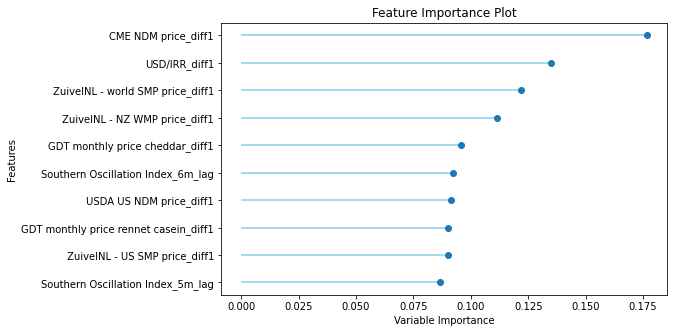

In [7]:
plot_model(lr_model,'feature')

In [8]:
rf_model = tune_model('rf' ,n_iter=100)
rf_model

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.6667,0.8500,0.8000,0.6667,0.7273,0.3077
1,0.7778,0.7500,1.0000,0.7143,0.8333,0.5263
2,0.8889,0.9500,0.8000,1.0000,0.8889,0.7805
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.7778,0.7500,0.5000,1.0000,0.6667,0.5263
6,0.8889,1.0000,0.7500,1.0000,0.8571,0.7692
7,0.8889,1.0000,1.0000,0.8000,0.8889,0.7805
8,0.8889,0.7500,0.7500,1.0000,0.8571,0.7692
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=6038,
                       verbose=0, warm_start=False)

In [9]:
evaluate_model(rf_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

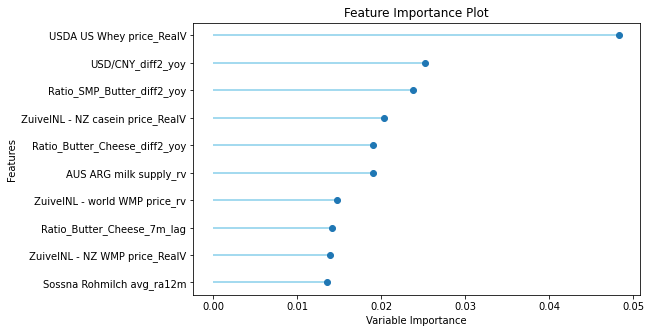

In [10]:
plot_model(rf_model,'feature')